# 🎤 Common Voice - Ray ile Ses Sınıflandırma

Bu notebook, Mozilla Common Voice veri setini kullanarak **Ray** framework'ü ile:
- **Cinsiyet (Gender)** tahmini
- **Yaş (Age)** tahmini  
- **Aksan (Accent)** tahmini

modellerini eğitir.

## Neden Ray?
- ✅ Python native (JVM yok)
- ✅ Otomatik bellek yönetimi
- ✅ Paralel feature extraction
- ✅ Colab ile mükemmel uyum
- ✅ sklearn, TensorFlow, PyTorch entegrasyonu


## 1. Kütüphanelerin Kurulumu


In [ ]:
# Gerekli kütüphaneleri kur
%pip install -q "ray[default]" kaggle librosa soundfile scikit-learn pandas numpy matplotlib seaborn tqdm joblib

print("✅ Tüm kütüphaneler kuruldu!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 146.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 46.6 MB/s eta 0:00:00
✅ Tüm kütüphaneler kuruldu!


In [ ]:
# Kütüphaneleri import et
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import time
import joblib
import psutil
import multiprocessing
warnings.filterwarnings('ignore')

# Ray
import ray

# Ses işleme
import librosa

# sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# =============================================================================
# SİSTEM BİLGİLERİNİ GÖSTER
# =============================================================================
print("="*60)
print("💻 SİSTEM BİLGİLERİ (Google Colab)")
print("="*60)

# CPU bilgisi
cpu_count = multiprocessing.cpu_count()
print(f"\n🔹 CPU Çekirdek Sayısı: {cpu_count}")

# RAM bilgisi
ram_gb = psutil.virtual_memory().total / (1024**3)
ram_available_gb = psutil.virtual_memory().available / (1024**3)
print(f"🔹 Toplam RAM: {ram_gb:.1f} GB")
print(f"🔹 Kullanılabilir RAM: {ram_available_gb:.1f} GB")

# Disk bilgisi
disk = psutil.disk_usage('/')
disk_total_gb = disk.total / (1024**3)
disk_free_gb = disk.free / (1024**3)
print(f"🔹 Toplam Disk: {disk_total_gb:.1f} GB")
print(f"🔹 Boş Disk: {disk_free_gb:.1f} GB")

# GPU kontrolü
try:
    import subprocess
    result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'],
                          capture_output=True, text=True)
    if result.returncode == 0:
        gpu_info = result.stdout.strip()
        print(f"🔹 GPU: {gpu_info}")
    else:
        print("🔹 GPU: Bulunamadı (CPU runtime)")
except:
    print("🔹 GPU: Bulunamadı (CPU runtime)")

# Colab Pro tahmini
if ram_gb > 20:
    colab_type = "Colab Pro+ (High-RAM)"
elif ram_gb > 12:
    colab_type = "Colab Pro"
else:
    colab_type = "Colab Free"
print(f"\n📌 Tahmin: {colab_type}")

print("="*60)
print(f"✅ Kütüphaneler yüklendi!")
print(f"   Ray version: {ray.__version__}")


💻 SİSTEM BİLGİLERİ (Google Colab)

🔹 CPU Çekirdek Sayısı: 12
🔹 Toplam RAM: 167.1 GB
🔹 Kullanılabilir RAM: 164.4 GB
🔹 Toplam Disk: 235.7 GB
🔹 Boş Disk: 196.9 GB
🔹 GPU: NVIDIA A100-SXM4-80GB, 81920 MiB

📌 Tahmin: Colab Pro+ (High-RAM)
✅ Kütüphaneler yüklendi!
   Ray version: 2.53.0


## 2. Google Drive Bağlantısı


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive bağlandı!")


Mounted at /content/drive
✅ Google Drive bağlandı!


## 3. Kaggle API Ayarları


In [ ]:
# # =============================================================================
# # KAGGLE API AYARLARI
# # =============================================================================
# # 1. kaggle.com → Account → Create New API Token
# # 2. kaggle.json dosyasını indirin
# # 3. Aşağıya yükleyin

# from google.colab import files

# print("📁 kaggle.json dosyanızı yükleyin:")
# uploaded = files.upload()

# # Kaggle klasörüne taşı
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# print("✅ Kaggle API yapılandırıldı!")


# =============================================================================
# KAGGLE API AYARLARI (Drive üzerinden)
# =============================================================================
import os

# Kaggle json dosyasının yolu
kaggle_json_path = "/content/drive/MyDrive/elif/kaggle.json"

# Kaggle klasörüne kopyala
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.system(f"cp {kaggle_json_path} ~/.kaggle/kaggle.json")
os.system("chmod 600 ~/.kaggle/kaggle.json")

print("✅ Kaggle API yapılandırıldı!")


✅ Kaggle API yapılandırıldı!


## 4. Veri Setini İndir


In [ ]:
# =============================================================================
# COMMON VOICE VERİ SETİNİ İNDİR
# =============================================================================

DATASET_NAME = "mozillaorg/common-voice"
DATA_DIR = "/content/common-voice"

print(f"📥 {DATASET_NAME} indiriliyor...")
print("⏳ Bu işlem birkaç dakika sürebilir...")

# Shell komutu olarak çalıştır (subprocess yerine - daha stabil)
!kaggle datasets download -d {DATASET_NAME} -p {DATA_DIR} --unzip

print(f"\n✅ Veri indirildi: {DATA_DIR}")
!ls -la {DATA_DIR}


📥 mozillaorg/common-voice indiriliyor...
⏳ Bu işlem birkaç dakika sürebilir...
Dataset URL: https://www.kaggle.com/datasets/mozillaorg/common-voice
License(s): CC0-1.0
 99% 11.9G/12.0G [00:31<00:00, 244MB/s]
100% 12.0G/12.0G [00:31<00:00, 406MB/s]

✅ Veri indirildi: /content/common-voice
total 35396
drwxr-xr-x 9 root root     4096 Dec 22 19:25 .
drwxr-xr-x 1 root root     4096 Dec 22 19:22 ..
drwxr-xr-x 3 root root     4096 Dec 22 19:23 cv-invalid
-rw-r--r-- 1 root root  2361277 Dec 22 19:23 cv-invalid.csv
drwxr-xr-x 3 root root     4096 Dec 22 19:23 cv-other-dev
-rw-r--r-- 1 root root   272718 Dec 22 19:23 cv-other-dev.csv
drwxr-xr-x 3 root root     4096 Dec 22 19:23 cv-other-test
-rw-r--r-- 1 root root   271587 Dec 22 19:23 cv-other-test.csv
drwxr-xr-x 3 root root     4096 Dec 22 19:23 cv-other-train
-rw-r--r-- 1 root root 13420832 Dec 22 19:23 cv-other-train.csv
drwxr-xr-x 3 root root     4096 Dec 22 19:24 cv-valid-dev
-rw-r--r-- 1 root root   388392 Dec 22 19:24 cv-valid-dev.csv
dr

## 5. Kullanılmayacak Dosyaları Sil (Yer Açmak İçin)


In [ ]:
import shutil

BASE_DIR = "/content/common-voice"

# Kullanılmayacak CSV'ler
unused_csvs = [
    f"{BASE_DIR}/cv-other-train.csv",
    f"{BASE_DIR}/cv-other-dev.csv",
    f"{BASE_DIR}/cv-other-test.csv",
    f"{BASE_DIR}/cv-invalid.csv"
]

for f in unused_csvs:
    if os.path.exists(f):
        os.remove(f)
        print(f"Deleted: {f}")

# Kullanılmayacak ses klasörleri
unused_dirs = [
    f"{BASE_DIR}/cv-other-train",
    f"{BASE_DIR}/cv-other-dev",
    f"{BASE_DIR}/cv-other-test",
    f"{BASE_DIR}/cv-invalid"
]

for d in unused_dirs:
    if os.path.exists(d):
        shutil.rmtree(d)
        print(f"Removed: {d}")

print("\n✅ Gereksiz dosyalar silindi!")
print("\nKalan dosyalar:")
for f in os.listdir(BASE_DIR):
    print(f"   - {f}")


Deleted: /content/common-voice/cv-other-train.csv
Deleted: /content/common-voice/cv-other-dev.csv
Deleted: /content/common-voice/cv-other-test.csv
Deleted: /content/common-voice/cv-invalid.csv
Removed: /content/common-voice/cv-other-train
Removed: /content/common-voice/cv-other-dev
Removed: /content/common-voice/cv-other-test
Removed: /content/common-voice/cv-invalid

✅ Gereksiz dosyalar silindi!

Kalan dosyalar:
   - cv-valid-train.csv
   - LICENSE.txt
   - cv-valid-dev
   - README.txt
   - cv-valid-test
   - cv-valid-test.csv
   - cv-valid-train
   - cv-valid-dev.csv


## 6. Veriyi Yükle ve Keşfet


In [ ]:
BASE_DIR = "/content/common-voice"

# CSV dosyalarını yükle
df_train = pd.read_csv(f"{BASE_DIR}/cv-valid-train.csv")
df_dev = pd.read_csv(f"{BASE_DIR}/cv-valid-dev.csv")
df_test = pd.read_csv(f"{BASE_DIR}/cv-valid-test.csv")

print(f"📊 Veri Boyutları:")
print(f"   Train: {len(df_train):,}")
print(f"   Dev: {len(df_dev):,}")
print(f"   Test: {len(df_test):,}")

print(f"\n📋 Sütunlar: {df_train.columns.tolist()}")
df_train.head()


📊 Veri Boyutları:
   Train: 195,776
   Dev: 4,076
   Test: 3,995

📋 Sütunlar: ['filename', 'text', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration']


,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [ ]:
# Eksik değer analizi
print("📊 Eksik Değer Analizi (Train):")
print(df_train[['age', 'gender', 'accent']].isnull().sum())

print("\n📊 Dağılımlar:")
print("\n🔹 Gender:")
print(df_train['gender'].value_counts())

print("\n🔹 Age:")
print(df_train['age'].value_counts())

print("\n🔹 Accent (Top 10):")
print(df_train['accent'].value_counts().head(10))


📊 Eksik Değer Analizi (Train):
age       122008
gender    121717
accent    131065
dtype: int64

📊 Dağılımlar:

🔹 Gender:
gender
male      55029
female    18249
other       781
Name: count, dtype: int64

🔹 Age:
age
twenties     23003
thirties     18303
fourties     11100
fifties       9466
teens         5441
sixties       4584
seventies     1632
eighties       239
Name: count, dtype: int64

🔹 Accent (Top 10):
accent
us             30997
england        14938
indian          4490
australia       4287
canada          3901
scotland        1556
african         1173
newzealand      1153
ireland          944
philippines      326
Name: count, dtype: int64


## 7. Veri Temizleme ve Preprocessing


In [ ]:
def clean_data(df):
    """
    Veriyi temizle:
    1. Null değerleri kaldır
    2. Gender: sadece male/female
    3. Accent: min 1000 örnek olanlar
    4. Age: young/middle/senior grupla
    """
    # Null değerleri kaldır
    df_clean = df.dropna(subset=['age', 'gender', 'accent']).copy()
    df_clean = df_clean[df_clean['age'] != '']
    df_clean = df_clean[df_clean['gender'] != '']
    df_clean = df_clean[df_clean['accent'] != '']

    # Gender: sadece male/female
    df_clean = df_clean[df_clean['gender'].isin(['male', 'female'])]

    # Accent: min 1000 örnek threshold (train verisi üzerinden)
    return df_clean

# İlk temizlik
df_train_clean = clean_data(df_train)
df_dev_clean = clean_data(df_dev)
df_test_clean = clean_data(df_test)

# Accent threshold uygula (train üzerinden valid aksanları bul)
accent_counts = df_train_clean['accent'].value_counts()
valid_accents = accent_counts[accent_counts >= 1000].index.tolist()

df_train_clean = df_train_clean[df_train_clean['accent'].isin(valid_accents)]
df_dev_clean = df_dev_clean[df_dev_clean['accent'].isin(valid_accents)]
df_test_clean = df_test_clean[df_test_clean['accent'].isin(valid_accents)]

# Age gruplandırma
def age_group(age):
    if age in ['teens', 'twenties', 'thirties']:
        return 'young'
    elif age in ['fourties', 'fifties']:
        return 'middle'
    else:  # sixties, seventies, eighties
        return 'senior'

df_train_clean['age_group'] = df_train_clean['age'].apply(age_group)
df_dev_clean['age_group'] = df_dev_clean['age'].apply(age_group)
df_test_clean['age_group'] = df_test_clean['age'].apply(age_group)

print(f"📊 Temizlenmiş Veri Boyutları:")
print(f"   Train: {len(df_train):,} → {len(df_train_clean):,}")
print(f"   Dev: {len(df_dev):,} → {len(df_dev_clean):,}")
print(f"   Test: {len(df_test):,} → {len(df_test_clean):,}")


📊 Temizlenmiş Veri Boyutları:
   Train: 195,776 → 60,322
   Dev: 4,076 → 1,270
   Test: 3,995 → 1,262


In [ ]:
# Temizlenmiş dağılımları göster
print("📊 Temizlenmiş Dağılımlar (Train):")

print("\n🔹 Gender:")
print(df_train_clean['gender'].value_counts())

print("\n🔹 Age Group:")
print(df_train_clean['age_group'].value_counts())

print("\n🔹 Accent:")
print(df_train_clean['accent'].value_counts())


📊 Temizlenmiş Dağılımlar (Train):

🔹 Gender:
gender
male      44388
female    15934
Name: count, dtype: int64

🔹 Age Group:
age_group
young     36177
middle    17922
senior     6223
Name: count, dtype: int64

🔹 Accent:
accent
us            29555
england       14704
indian         4445
australia      4076
canada         3760
scotland       1480
newzealand     1153
african        1149
Name: count, dtype: int64





## 8. Label Encoding:


In [ ]:
# Label Encoder'ları oluştur
le_gender = LabelEncoder()
le_age = LabelEncoder()
le_accent = LabelEncoder()

# Train verisi üzerinde fit et
le_gender.fit(df_train_clean['gender'])
le_age.fit(df_train_clean['age_group'])
le_accent.fit(df_train_clean['accent'])

# Transform uygula
df_train_clean = df_train_clean.copy()
df_dev_clean = df_dev_clean.copy()
df_test_clean = df_test_clean.copy()

df_train_clean['gender_label'] = le_gender.transform(df_train_clean['gender'])
df_train_clean['age_label'] = le_age.transform(df_train_clean['age_group'])
df_train_clean['accent_label'] = le_accent.transform(df_train_clean['accent'])

df_dev_clean['gender_label'] = le_gender.transform(df_dev_clean['gender'])
df_dev_clean['age_label'] = le_age.transform(df_dev_clean['age_group'])
df_dev_clean['accent_label'] = le_accent.transform(df_dev_clean['accent'])

df_test_clean['gender_label'] = le_gender.transform(df_test_clean['gender'])
df_test_clean['age_label'] = le_age.transform(df_test_clean['age_group'])
df_test_clean['accent_label'] = le_accent.transform(df_test_clean['accent'])

print("✅ Label encoding tamamlandı!")
print(f"\n🔹 Gender: {dict(zip(le_gender.classes_, range(len(le_gender.classes_))))}")
print(f"🔹 Age: {dict(zip(le_age.classes_, range(len(le_age.classes_))))}")
print(f"🔹 Accent: {dict(zip(le_accent.classes_, range(len(le_accent.classes_))))}")


✅ Label encoding tamamlandı!

🔹 Gender: {'female': 0, 'male': 1}
🔹 Age: {'middle': 0, 'senior': 1, 'young': 2}
🔹 Accent: {'african': 0, 'australia': 1, 'canada': 2, 'england': 3, 'indian': 4, 'newzealand': 5, 'scotland': 6, 'us': 7}


## 9. Ray Başlat


In [ ]:
# Ray'i başlat - Otomatik CPU sayısı algılama
if ray.is_initialized():
    ray.shutdown()

# CPU sayısını otomatik algıla
num_cpus = multiprocessing.cpu_count()

ray.init(
    num_cpus=num_cpus,  # Otomatik algılanan CPU sayısı
    ignore_reinit_error=True,
    logging_level="ERROR"
)

print("✅ Ray başlatıldı!")
print(f"   Kullanılan CPU: {num_cpus}")
print(f"   Ray CPU: {ray.available_resources().get('CPU', 0)}")
print(f"   Ray Memory: {ray.available_resources().get('memory', 0) / 1e9:.1f} GB")


✅ Ray başlatıldı!
   Kullanılan CPU: 12
   Ray CPU: 12.0
   Ray Memory: 125.1 GB


## 10. Feature Extraction Fonksiyonu


In [ ]:
BASE_DIR = "/content/common-voice"

def build_full_path(filename):
    """Dosya yolunu tam path'e çevir"""
    # filename: cv-valid-train/sample-000005.mp3
    split_dir = filename.split("/")[0]
    return f"{BASE_DIR}/{split_dir}/{split_dir}/{filename.split('/')[1]}"

def extract_features_single(file_path, sr=16000, duration=5):
    """
    Tek ses dosyasından özellik çıkar

    Çıkarılan özellikler (46 boyut):
    - MFCC mean (13) + std (13) = 26
    - Zero Crossing Rate mean + std = 2
    - Spectral Centroid mean + std = 2
    - Spectral Rolloff mean + std = 2
    - Chroma mean (12) = 12
    - Spectral Bandwidth mean + std = 2
    TOPLAM: 46
    """
    try:
        # Ses dosyasını yükle
        y, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Ses çok kısaysa padding
        if len(y) < sr:
            y = np.pad(y, (0, sr - len(y)))

        # 1. MFCC (13 katsayı)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)

        # 2. Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)

        # 3. Spectral Centroid
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        cent_mean = np.mean(cent)
        cent_std = np.std(cent)

        # 4. Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        rolloff_mean = np.mean(rolloff)
        rolloff_std = np.std(rolloff)

        # 5. Chroma (12 frekans bandı)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # 6. Spectral Bandwidth
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        bandwidth_mean = np.mean(bandwidth)
        bandwidth_std = np.std(bandwidth)

        # Tüm özellikleri birleştir (46 boyut)
        features = np.concatenate([
            mfcc_mean,                          # 13
            mfcc_std,                           # 13
            [zcr_mean, zcr_std],                # 2
            [cent_mean, cent_std],              # 2
            [rolloff_mean, rolloff_std],        # 2
            chroma_mean,                        # 12
            [bandwidth_mean, bandwidth_std]     # 2
        ])

        return features

    except Exception as e:
        # Hata durumunda sıfır vektör
        return np.zeros(46)

# Test et
test_file = build_full_path(df_train_clean['filename'].iloc[0])
print(f"Test dosyası: {test_file}")
print(f"Dosya var mı: {os.path.exists(test_file)}")

if os.path.exists(test_file):
    test_features = extract_features_single(test_file)
    print(f"\n✅ Feature boyutu: {test_features.shape}")
    print(f"İlk 5 özellik: {test_features[:5]}")


Test dosyası: /content/common-voice/cv-valid-train/cv-valid-train/sample-000005.mp3
Dosya var mı: True

✅ Feature boyutu: (46,)
İlk 5 özellik: [-524.77197266   75.91769409   25.65176201   40.18151093  -14.9677887 ]


## 11. Ray ile Paralel Feature Extraction


In [ ]:
@ray.remote
def extract_features_ray(filename):
    """Ray remote fonksiyonu - paralel çalışır"""
    import librosa
    import numpy as np

    BASE_DIR = "/content/common-voice"
    split_dir = filename.split("/")[0]
    file_path = f"{BASE_DIR}/{split_dir}/{split_dir}/{filename.split('/')[1]}"

    try:
        y, sr = librosa.load(file_path, sr=16000, duration=5)

        if len(y) < sr:
            y = np.pad(y, (0, sr - len(y)))

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)

        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean, zcr_std = np.mean(zcr), np.std(zcr)

        cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        cent_mean, cent_std = np.mean(cent), np.std(cent)

        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        rolloff_mean, rolloff_std = np.mean(rolloff), np.std(rolloff)

        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        bandwidth_mean, bandwidth_std = np.mean(bandwidth), np.std(bandwidth)

        features = np.concatenate([
            mfcc_mean, mfcc_std,
            [zcr_mean, zcr_std, cent_mean, cent_std],
            [rolloff_mean, rolloff_std],
            chroma_mean,
            [bandwidth_mean, bandwidth_std]
        ])

        return features

    except Exception:
        return np.zeros(46)

def extract_all_features_parallel(filenames, batch_size=1000):
    """
    Tüm dosyalar için paralel feature extraction
    Batch'ler halinde işler (bellek yönetimi için)
    """
    all_features = []
    total = len(filenames)

    print(f"🎵 Feature extraction başlıyor...")
    print(f"   Toplam: {total:,} dosya")
    print(f"   Batch size: {batch_size}")

    start_time = time.time()

    for i in tqdm(range(0, total, batch_size), desc="Batch"):
        batch = filenames[i:i+batch_size]

        # Ray task'ları oluştur
        futures = [extract_features_ray.remote(f) for f in batch]

        # Sonuçları al
        batch_features = ray.get(futures)
        all_features.extend(batch_features)

    elapsed = time.time() - start_time
    print(f"\n✅ Feature extraction tamamlandı!")
    print(f"⏱️  Süre: {elapsed/60:.1f} dakika")

    return np.array(all_features)

print("✅ Paralel extraction fonksiyonu hazır!")


✅ Paralel extraction fonksiyonu hazır!


In [ ]:
# Feature extraction - TRAIN
print("="*60)
print("📦 TRAIN VERİSİ")
print("="*60)

# Süreyi kaydet (benchmark için)
ray_train_start = time.time()

train_filenames = df_train_clean['filename'].tolist()
X_train = extract_all_features_parallel(train_filenames, batch_size=500)

ray_train_time = (time.time() - ray_train_start) / 60  # dakika

print(f"\n📊 X_train shape: {X_train.shape}")
print(f"⏱️  Train feature extraction: {ray_train_time:.1f} dakika")


📦 TRAIN VERİSİ
🎵 Feature extraction başlıyor...
   Toplam: 60,322 dosya
   Batch size: 500


Batch:  30%|██▉       | 36/121 [01:53<04:18,  3.04s/it](extract_features_ray pid=5206) /usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
(extract_features_ray pid=5206)   return pitch_tuning(
Batch:  43%|████▎     | 52/121 [02:42<03:29,  3.03s/it](extract_features_ray pid=5203) /usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
(extract_features_ray pid=5203)   return pitch_tuning(
Batch: 100%|██████████| 121/121 [06:14<00:00,  3.10s/it]


✅ Feature extraction tamamlandı!
⏱️  Süre: 6.2 dakika

📊 X_train shape: (60322, 46)
⏱️  Train feature extraction: 6.3 dakika


In [ ]:
# Feature extraction - TEST
print("="*60)
print("📦 TEST VERİSİ")
print("="*60)

ray_test_start = time.time()

test_filenames = df_test_clean['filename'].tolist()
X_test = extract_all_features_parallel(test_filenames, batch_size=500)

ray_test_time = (time.time() - ray_test_start) / 60  # dakika

# Toplam Ray feature extraction süresi
ray_total_fe_time = ray_train_time + ray_test_time

print(f"\n📊 X_test shape: {X_test.shape}")
print(f"⏱️  Test feature extraction: {ray_test_time:.1f} dakika")
print(f"\n📊 TOPLAM RAY FE SÜRESİ: {ray_total_fe_time:.1f} dakika")


📦 TEST VERİSİ
🎵 Feature extraction başlıyor...
   Toplam: 1,262 dosya
   Batch size: 500


Batch: 100%|██████████| 3/3 [00:08<00:00,  2.81s/it]


✅ Feature extraction tamamlandı!
⏱️  Süre: 0.1 dakika

📊 X_test shape: (1262, 46)
⏱️  Test feature extraction: 0.1 dakika

📊 TOPLAM RAY FE SÜRESİ: 6.4 dakika


In [ ]:
# Labels
y_train_gender = df_train_clean['gender_label'].values
y_test_gender = df_test_clean['gender_label'].values

y_train_age = df_train_clean['age_label'].values
y_test_age = df_test_clean['age_label'].values

y_train_accent = df_train_clean['accent_label'].values
y_test_accent = df_test_clean['accent_label'].values

print("✅ Labels hazır!")
print(f"   y_train_gender: {y_train_gender.shape}")
print(f"   y_train_age: {y_train_age.shape}")
print(f"   y_train_accent: {y_train_accent.shape}")


✅ Labels hazır!
   y_train_gender: (60322,)
   y_train_age: (60322,)
   y_train_accent: (60322,)


## 12. Verileri Kaydet (Güvenlik - Runtime çökerse kaybolmasın!)


In [ ]:
# Verileri Google Drive'a kaydet
SAVE_PATH = "/content/drive/MyDrive/cv_ray_features"
os.makedirs(SAVE_PATH, exist_ok=True)

# Features
np.save(f"{SAVE_PATH}/X_train.npy", X_train)
np.save(f"{SAVE_PATH}/X_test.npy", X_test)

# Labels
np.save(f"{SAVE_PATH}/y_train_gender.npy", y_train_gender)
np.save(f"{SAVE_PATH}/y_test_gender.npy", y_test_gender)
np.save(f"{SAVE_PATH}/y_train_age.npy", y_train_age)
np.save(f"{SAVE_PATH}/y_test_age.npy", y_test_age)
np.save(f"{SAVE_PATH}/y_train_accent.npy", y_train_accent)
np.save(f"{SAVE_PATH}/y_test_accent.npy", y_test_accent)

# Label Encoders
joblib.dump(le_gender, f"{SAVE_PATH}/le_gender.pkl")
joblib.dump(le_age, f"{SAVE_PATH}/le_age.pkl")
joblib.dump(le_accent, f"{SAVE_PATH}/le_accent.pkl")

# =============================================================================
# BENCHMARK SONUÇLARINI KAYDET (Spark ile karşılaştırma için)
# =============================================================================
import json
from datetime import datetime

BENCHMARK_PATH = "/content/drive/MyDrive/cv_benchmarks"
os.makedirs(BENCHMARK_PATH, exist_ok=True)

ray_benchmark = {
    "framework": "Ray",
    "timestamp": datetime.now().isoformat(),
    "system": {
        "cpu_count": cpu_count,
        "ram_gb": round(ram_gb, 1),
        "colab_type": colab_type
    },
    "feature_extraction": {
        "train_samples": len(train_filenames),
        "test_samples": len(test_filenames),
        "train_time_minutes": round(ray_train_time, 2),
        "test_time_minutes": round(ray_test_time, 2),
        "total_time_minutes": round(ray_total_fe_time, 2)
    },
    "status": "completed",
    "crashed": False
}

# JSON olarak kaydet
with open(f"{BENCHMARK_PATH}/ray_benchmark.json", 'w') as f:
    json.dump(ray_benchmark, f, indent=2)

print("✅ Veriler Google Drive'a kaydedildi!")
print(f"📁 Konum: {SAVE_PATH}")
print(f"\n📊 Benchmark kaydedildi: {BENCHMARK_PATH}/ray_benchmark.json")
print("\n⚠️ Artık runtime çökse bile veriler güvende!")


✅ Veriler Google Drive'a kaydedildi!
📁 Konum: /content/drive/MyDrive/cv_ray_features

📊 Benchmark kaydedildi: /content/drive/MyDrive/cv_benchmarks/ray_benchmark.json

⚠️ Artık runtime çökse bile veriler güvende!


## 13. (Opsiyonel) Kaydedilmiş Verileri Yükle

Runtime çöktüyse bu hücreyi çalıştırın:


In [ ]:

# # Runtime çöktüyse bu hücreyi çalıştırın (yorum satırlarını kaldırın)
# SAVE_PATH = "/content/drive/MyDrive/cv_ray_features"

# X_train = np.load(f"{SAVE_PATH}/X_train.npy")
# X_test = np.load(f"{SAVE_PATH}/X_test.npy")

# y_train_gender = np.load(f"{SAVE_PATH}/y_train_gender.npy")
# y_test_gender = np.load(f"{SAVE_PATH}/y_test_gender.npy")
# y_train_age = np.load(f"{SAVE_PATH}/y_train_age.npy")
# y_test_age = np.load(f"{SAVE_PATH}/y_test_age.npy")
# y_train_accent = np.load(f"{SAVE_PATH}/y_train_accent.npy")
# y_test_accent = np.load(f"{SAVE_PATH}/y_test_accent.npy")

# le_gender = joblib.load(f"{SAVE_PATH}/le_gender.pkl")
# le_age = joblib.load(f"{SAVE_PATH}/le_age.pkl")
# le_accent = joblib.load(f"{SAVE_PATH}/le_accent.pkl")

# print("✅ Veriler yüklendi!")
# print(f"   X_train: {X_train.shape}")
# print(f"   X_test: {X_test.shape}")


## 14. Feature Normalization


In [ ]:
# StandardScaler ile normalize et
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features normalize edildi!")
print(f"   X_train mean: {X_train_scaled.mean():.4f}")
print(f"   X_train std: {X_train_scaled.std():.4f}")


✅ Features normalize edildi!
   X_train mean: -0.0000
   X_train std: 1.0000


## 15. Model Eğitimi - Gender (Cinsiyet)


In [ ]:
print("="*60)
print("🎯 GENDER (CİNSİYET) SINIFLANDIRMA")
print("="*60)

# RandomForest
print("\n📌 RandomForest eğitiliyor...")
start_time = time.time()
rf_gender = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_gender.fit(X_train_scaled, y_train_gender)
rf_gender_time = time.time() - start_time

y_pred_rf_gender = rf_gender.predict(X_test_scaled)
rf_acc_gender = accuracy_score(y_test_gender, y_pred_rf_gender)
print(f"   ✅ RandomForest - Accuracy: {rf_acc_gender:.4f}, Süre: {rf_gender_time:.1f}s")

# SVM RBF
print("\n📌 SVM RBF eğitiliyor...")
start_time = time.time()
svm_gender = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_gender.fit(X_train_scaled, y_train_gender)
svm_gender_time = time.time() - start_time

y_pred_svm_gender = svm_gender.predict(X_test_scaled)
svm_acc_gender = accuracy_score(y_test_gender, y_pred_svm_gender)
print(f"   ✅ SVM RBF - Accuracy: {svm_acc_gender:.4f}, Süre: {svm_gender_time:.1f}s")

# Classification Report
print("\n📊 SVM RBF Classification Report (Gender):")
print(classification_report(y_test_gender, y_pred_svm_gender, target_names=le_gender.classes_))


🎯 GENDER (CİNSİYET) SINIFLANDIRMA

📌 RandomForest eğitiliyor...
   ✅ RandomForest - Accuracy: 0.8590, Süre: 5.6s

📌 SVM RBF eğitiliyor...
   ✅ SVM RBF - Accuracy: 0.9588, Süre: 112.1s

📊 SVM RBF Classification Report (Gender):
              precision    recall  f1-score   support

      female       0.96      0.89      0.92       344
        male       0.96      0.98      0.97       918

    accuracy                           0.96      1262
   macro avg       0.96      0.94      0.95      1262
weighted avg       0.96      0.96      0.96      1262



## 16. Model Eğitimi - Age (Yaş)


In [ ]:
print("="*60)
print("🎯 AGE (YAŞ) SINIFLANDIRMA")
print(f"   Sınıflar: {list(le_age.classes_)}")
print("="*60)

# RandomForest
print("\n📌 RandomForest eğitiliyor...")
start_time = time.time()
rf_age = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_age.fit(X_train_scaled, y_train_age)
rf_age_time = time.time() - start_time

y_pred_rf_age = rf_age.predict(X_test_scaled)
rf_acc_age = accuracy_score(y_test_age, y_pred_rf_age)
print(f"   ✅ RandomForest - Accuracy: {rf_acc_age:.4f}, Süre: {rf_age_time:.1f}s")

# SVM RBF
print("\n📌 SVM RBF eğitiliyor...")
start_time = time.time()
svm_age = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_age.fit(X_train_scaled, y_train_age)
svm_age_time = time.time() - start_time

y_pred_svm_age = svm_age.predict(X_test_scaled)
svm_acc_age = accuracy_score(y_test_age, y_pred_svm_age)
print(f"   ✅ SVM RBF - Accuracy: {svm_acc_age:.4f}, Süre: {svm_age_time:.1f}s")

# Classification Report
print("\n📊 SVM RBF Classification Report (Age):")
print(classification_report(y_test_age, y_pred_svm_age, target_names=le_age.classes_))


🎯 AGE (YAŞ) SINIFLANDIRMA
   Sınıflar: ['middle', 'senior', 'young']

📌 RandomForest eğitiliyor...
   ✅ RandomForest - Accuracy: 0.6561, Süre: 6.1s

📌 SVM RBF eğitiliyor...
   ✅ SVM RBF - Accuracy: 0.8447, Süre: 272.9s

📊 SVM RBF Classification Report (Age):
              precision    recall  f1-score   support

      middle       0.88      0.65      0.75       380
      senior       0.96      0.69      0.80       123
       young       0.82      0.97      0.89       759

    accuracy                           0.84      1262
   macro avg       0.89      0.77      0.81      1262
weighted avg       0.85      0.84      0.84      1262



## 17. Model Eğitimi - Accent (Aksan)


In [ ]:
print("="*60)
print("🎯 ACCENT (AKSAN) SINIFLANDIRMA")
print(f"   {len(le_accent.classes_)} farklı aksan: {list(le_accent.classes_)}")
print("="*60)

# RandomForest
print("\n📌 RandomForest eğitiliyor...")
start_time = time.time()
rf_accent = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)
rf_accent.fit(X_train_scaled, y_train_accent)
rf_accent_time = time.time() - start_time

y_pred_rf_accent = rf_accent.predict(X_test_scaled)
rf_acc_accent = accuracy_score(y_test_accent, y_pred_rf_accent)
print(f"   ✅ RandomForest - Accuracy: {rf_acc_accent:.4f}, Süre: {rf_accent_time:.1f}s")

# SVM RBF
print("\n📌 SVM RBF eğitiliyor...")
start_time = time.time()
svm_accent = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_accent.fit(X_train_scaled, y_train_accent)
svm_accent_time = time.time() - start_time

y_pred_svm_accent = svm_accent.predict(X_test_scaled)
svm_acc_accent = accuracy_score(y_test_accent, y_pred_svm_accent)
print(f"   ✅ SVM RBF - Accuracy: {svm_acc_accent:.4f}, Süre: {svm_accent_time:.1f}s")

# Classification Report
print("\n📊 SVM RBF Classification Report (Accent):")
print(classification_report(y_test_accent, y_pred_svm_accent, target_names=le_accent.classes_))


🎯 ACCENT (AKSAN) SINIFLANDIRMA
   8 farklı aksan: ['african', 'australia', 'canada', 'england', 'indian', 'newzealand', 'scotland', 'us']

📌 RandomForest eğitiliyor...
   ✅ RandomForest - Accuracy: 0.5959, Süre: 8.1s

📌 SVM RBF eğitiliyor...
   ✅ SVM RBF - Accuracy: 0.7884, Süre: 304.7s

📊 SVM RBF Classification Report (Accent):
              precision    recall  f1-score   support

     african       1.00      0.54      0.70        24
   australia       0.94      0.52      0.67        90
      canada       0.98      0.45      0.62        99
     england       0.81      0.73      0.77       294
      indian       0.91      0.66      0.76        90
  newzealand       1.00      0.50      0.67        16
    scotland       0.90      0.58      0.71        31
          us       0.74      0.95      0.84       618

    accuracy                           0.79      1262
   macro avg       0.91      0.62      0.72      1262
weighted avg       0.81      0.79      0.78      1262



## 18. Sonuç Özeti


In [ ]:
print("="*70)
print("📊 TÜM MODEL SONUÇLARI - KARŞILAŞTIRMA")
print("="*70)

print("\n🎯 GENDER (Cinsiyet) Sınıflandırma:")
print(f"   {'Model':<20} {'Accuracy':<12}")
print(f"   {'-'*32}")
print(f"   {'RandomForest':<20} {rf_acc_gender:<12.4f}")
print(f"   {'SVM RBF':<20} {svm_acc_gender:<12.4f}")

print("\n🎯 AGE (Yaş) Sınıflandırma:")
print(f"   {'Model':<20} {'Accuracy':<12}")
print(f"   {'-'*32}")
print(f"   {'RandomForest':<20} {rf_acc_age:<12.4f}")
print(f"   {'SVM RBF':<20} {svm_acc_age:<12.4f}")

print("\n🎯 ACCENT (Aksan) Sınıflandırma:")
print(f"   {'Model':<20} {'Accuracy':<12}")
print(f"   {'-'*32}")
print(f"   {'RandomForest':<20} {rf_acc_accent:<12.4f}")
print(f"   {'SVM RBF':<20} {svm_acc_accent:<12.4f}")

print("\n" + "="*70)
print("✅ Tüm modeller başarıyla eğitildi ve değerlendirildi!")
print("="*70)


📊 TÜM MODEL SONUÇLARI - KARŞILAŞTIRMA

🎯 GENDER (Cinsiyet) Sınıflandırma:
   Model                Accuracy    
   --------------------------------
   RandomForest         0.8590      
   SVM RBF              0.9588      

🎯 AGE (Yaş) Sınıflandırma:
   Model                Accuracy    
   --------------------------------
   RandomForest         0.6561      
   SVM RBF              0.8447      

🎯 ACCENT (Aksan) Sınıflandırma:
   Model                Accuracy    
   --------------------------------
   RandomForest         0.5959      
   SVM RBF              0.7884      

✅ Tüm modeller başarıyla eğitildi ve değerlendirildi!


## 19. Confusion Matrix Görselleştirme


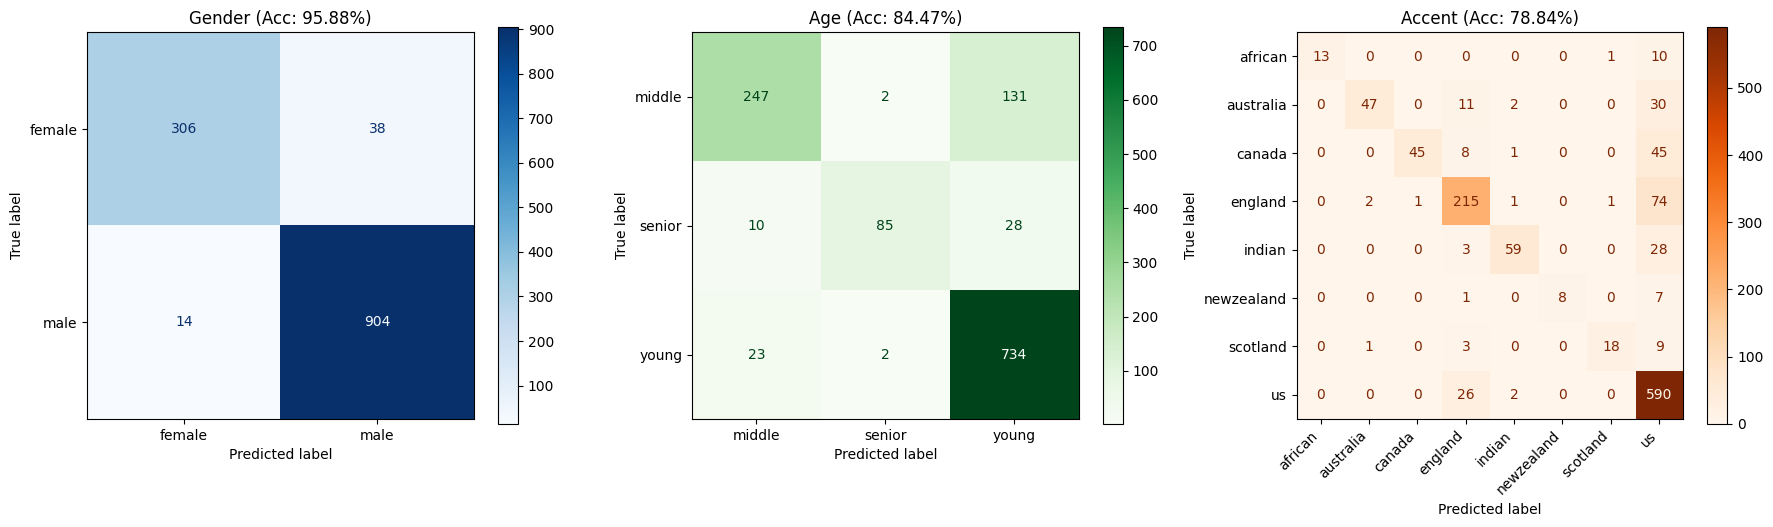


✅ Confusion matrix görseli kaydedildi!


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gender Confusion Matrix
cm_gender = confusion_matrix(y_test_gender, y_pred_svm_gender)
disp_gender = ConfusionMatrixDisplay(confusion_matrix=cm_gender, display_labels=le_gender.classes_)
disp_gender.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title(f"Gender (Acc: {svm_acc_gender:.2%})")

# Age Confusion Matrix
cm_age = confusion_matrix(y_test_age, y_pred_svm_age)
disp_age = ConfusionMatrixDisplay(confusion_matrix=cm_age, display_labels=le_age.classes_)
disp_age.plot(ax=axes[1], cmap=plt.cm.Greens)
axes[1].set_title(f"Age (Acc: {svm_acc_age:.2%})")

# Accent Confusion Matrix
cm_accent = confusion_matrix(y_test_accent, y_pred_svm_accent)
disp_accent = ConfusionMatrixDisplay(confusion_matrix=cm_accent, display_labels=le_accent.classes_)
disp_accent.plot(ax=axes[2], cmap=plt.cm.Oranges)
axes[2].set_title(f"Accent (Acc: {svm_acc_accent:.2%})")
plt.setp(axes[2].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/confusion_matrices_ray.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrix görseli kaydedildi!")


## 20. Cross Validation


In [ ]:
print("="*60)
print("📊 CROSS VALIDATION (5-Fold)")
print("="*60)

# Gender CV
print("\n🔹 Gender - SVM RBF:")
cv_gender = cross_val_score(svm_gender, X_train_scaled, y_train_gender, cv=5)
print(f"   Scores: {cv_gender}")
print(f"   Mean: {cv_gender.mean():.4f} (+/- {cv_gender.std()*2:.4f})")

# Age CV
print("\n🔹 Age - SVM RBF:")
cv_age = cross_val_score(svm_age, X_train_scaled, y_train_age, cv=5)
print(f"   Scores: {cv_age}")
print(f"   Mean: {cv_age.mean():.4f} (+/- {cv_age.std()*2:.4f})")

# Accent CV
print("\n🔹 Accent - SVM RBF:")
cv_accent = cross_val_score(svm_accent, X_train_scaled, y_train_accent, cv=5)
print(f"   Scores: {cv_accent}")
print(f"   Mean: {cv_accent.mean():.4f} (+/- {cv_accent.std()*2:.4f})")


📊 CROSS VALIDATION (5-Fold)

🔹 Gender - SVM RBF:
   Scores: [0.95466225 0.95482801 0.95242042 0.94893899 0.9507626 ]
   Mean: 0.9523 (+/- 0.0045)

🔹 Age - SVM RBF:
   Scores: [0.84649814 0.85329465 0.8512931  0.84714854 0.84905504]
   Mean: 0.8495 (+/- 0.0051)

🔹 Accent - SVM RBF:
   Scores: [0.77546622 0.7787816  0.78522878 0.77122016 0.77884615]
   Mean: 0.7779 (+/- 0.0092)


## 21.A Multi-Label Accuracy Analizi

3 modelin (Gender, Age, Accent) birlikte doğruluk analizi:
- Tüm etiketlerin doğru tahmin edilme oranı
- Kombinasyon bazlı doğruluk dağılımı
- Her örnek için kaç etiket doğru?


In [ ]:
# =============================================================================
# MULTI-LABEL ACCURACY ANALİZİ
# =============================================================================
# 3 model birlikte değerlendirildiğinde:
# - Gender + Age + Accent hepsinin doğru olma oranı
# - Kombinasyon bazlı analiz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

print("="*70)
print("📊 MULTI-LABEL ACCURACY ANALİZİ")
print("="*70)

# ---------------------------------------------------------------------
# 1️⃣ Her etiket için doğru/yanlış (1=doğru, 0=yanlış)
# ---------------------------------------------------------------------
df_multi = pd.DataFrame({
    'gender_true': y_test_gender,
    'age_true': y_test_age,
    'accent_true': y_test_accent,
    'gender_pred': y_pred_svm_gender,
    'age_pred': y_pred_svm_age,
    'accent_pred': y_pred_svm_accent
})

# Her etiket için doğruluk
df_multi['gender_correct'] = (df_multi['gender_true'] == df_multi['gender_pred']).astype(int)
df_multi['age_correct'] = (df_multi['age_true'] == df_multi['age_pred']).astype(int)
df_multi['accent_correct'] = (df_multi['accent_true'] == df_multi['accent_pred']).astype(int)

# ---------------------------------------------------------------------
# 2️⃣ Multi-label Accuracy (Tüm etiketler doğru)
# ---------------------------------------------------------------------
df_multi['all_correct'] = (df_multi['gender_correct'] & df_multi['age_correct'] & df_multi['accent_correct'])
multi_label_acc = df_multi['all_correct'].mean()

# Bireysel accuracy'ler
gender_acc = df_multi['gender_correct'].mean()
age_acc = df_multi['age_correct'].mean()
accent_acc = df_multi['accent_correct'].mean()

print(f"\n🎯 BİREYSEL MODEL ACCURACY:")
print(f"   Gender:  {gender_acc:.2%}")
print(f"   Age:     {age_acc:.2%}")
print(f"   Accent:  {accent_acc:.2%}")

print(f"\n🎯 MULTI-LABEL ACCURACY (3'ü de doğru):")
print(f"   ✅ {multi_label_acc:.2%}")

# ---------------------------------------------------------------------
# 3️⃣ Kaç etiket doğru dağılımı
# ---------------------------------------------------------------------
df_multi['correct_count'] = df_multi['gender_correct'] + df_multi['age_correct'] + df_multi['accent_correct']

correct_distribution = df_multi['correct_count'].value_counts().sort_index()
print(f"\n📊 DOĞRU ETİKET SAYISI DAĞILIMI:")
for count, num in correct_distribution.items():
    pct = num / len(df_multi) * 100
    print(f"   {count} doğru: {num:,} örnek ({pct:.1f}%)")

# ---------------------------------------------------------------------
# 4️⃣ Kombinasyon bazlı analiz (G=Gender, A=Age, C=Accent)
# ---------------------------------------------------------------------
# Kombinasyonları string olarak etiketle
df_multi['combo'] = df_multi.apply(
    lambda row: f"G{'✓' if row['gender_correct'] else '✗'} A{'✓' if row['age_correct'] else '✗'} C{'✓' if row['accent_correct'] else '✗'}",
    axis=1
)

combo_counts = df_multi['combo'].value_counts()
print(f"\n📊 KOMBİNASYON BAZLI DAĞILIM:")
print(f"   {'Kombinasyon':<20} {'Sayı':<10} {'Oran':<10}")
print(f"   {'-'*40}")
for combo, count in combo_counts.items():
    pct = count / len(df_multi) * 100
    print(f"   {combo:<20} {count:<10} {pct:.1f}%")

print("\n" + "="*70)


📊 MULTI-LABEL ACCURACY ANALİZİ

🎯 BİREYSEL MODEL ACCURACY:
   Gender:  95.88%
   Age:     84.47%
   Accent:  78.84%

🎯 MULTI-LABEL ACCURACY (3'ü de doğru):
   ✅ 67.19%

📊 DOĞRU ETİKET SAYISI DAĞILIMI:
   0 doğru: 7 örnek (0.6%)
   1 doğru: 87 örnek (6.9%)
   2 doğru: 320 örnek (25.4%)
   3 doğru: 848 örnek (67.2%)

📊 KOMBİNASYON BAZLI DAĞILIM:
   Kombinasyon          Sayı       Oran      
   ----------------------------------------
   G✓ A✓ C✓             848        67.2%
   G✓ A✓ C✗             181        14.3%
   G✓ A✗ C✓             114        9.0%
   G✓ A✗ C✗             67         5.3%
   G✗ A✓ C✓             25         2.0%
   G✗ A✓ C✗             12         1.0%
   G✗ A✗ C✓             8          0.6%
   G✗ A✗ C✗             7          0.6%



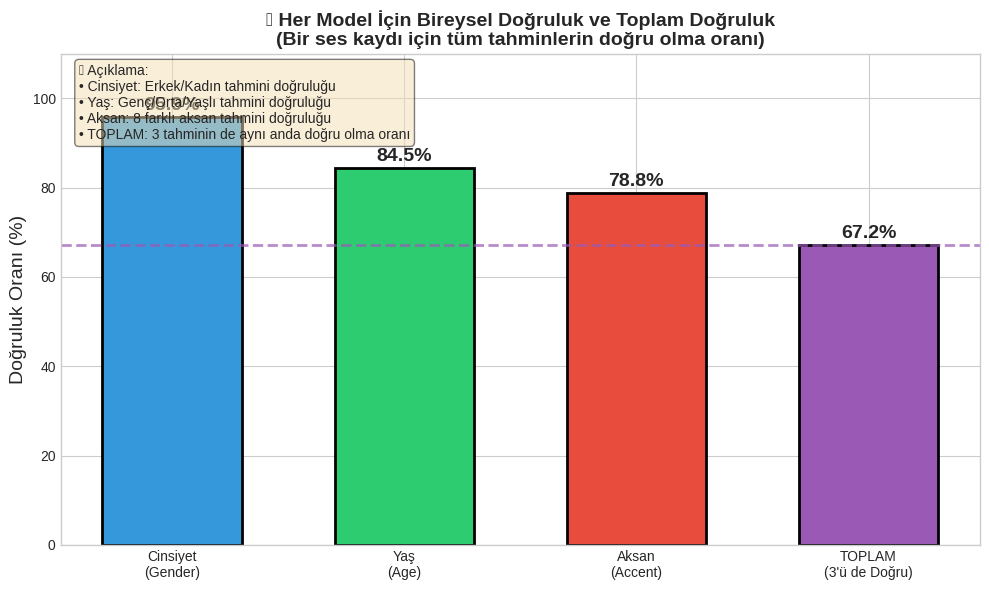

✅ Grafik 1 kaydedildi: 1_bireysel_model_accuracy.png


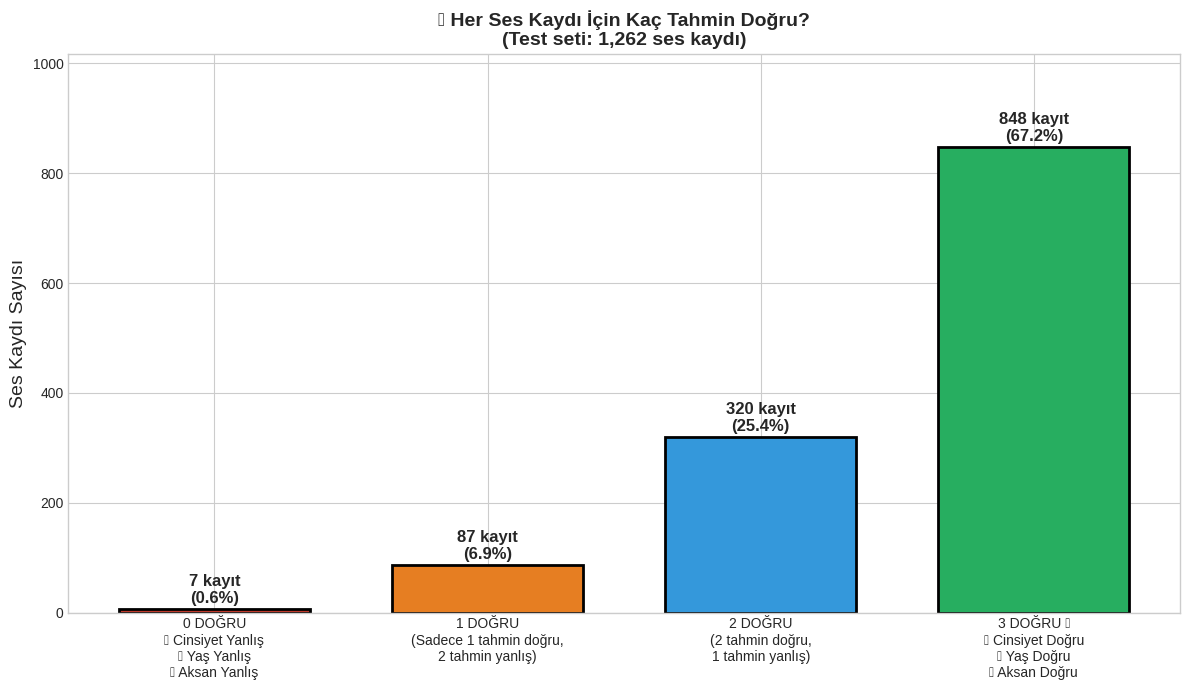

✅ Grafik 2 kaydedildi: 2_kac_etiket_dogru.png


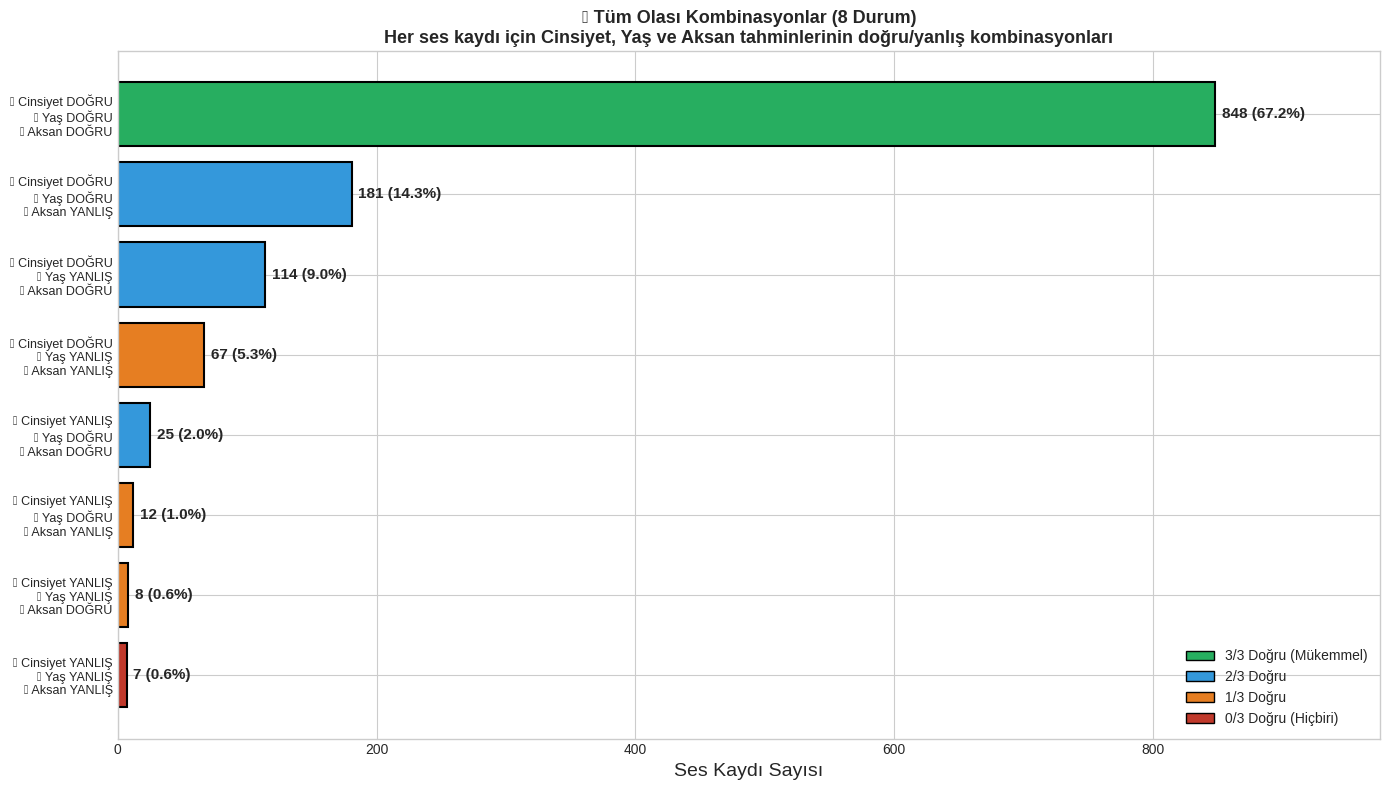

✅ Grafik 3 kaydedildi: 3_tum_kombinasyonlar.png


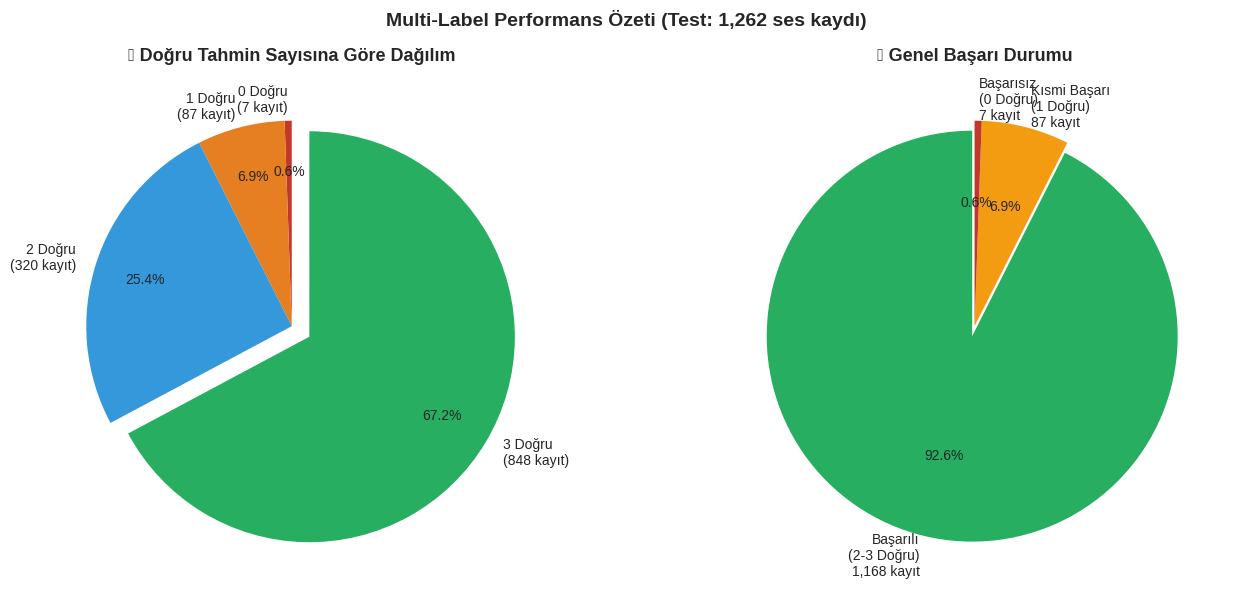

✅ Grafik 4 kaydedildi: 4_ozet_pasta_grafigi.png

📊 MULTI-LABEL ACCURACY SONUÇ ÖZETİ

┌─────────────────────────────────────────────────────────────────┐
│                    BİREYSEL MODEL SONUÇLARI                     │
├─────────────────────────────────────────────────────────────────┤
│  🔹 Cinsiyet (Gender) Doğruluğu:    95.88%                   │
│  🔹 Yaş (Age) Doğruluğu:            84.47%                   │
│  🔹 Aksan (Accent) Doğruluğu:       78.84%                   │
├─────────────────────────────────────────────────────────────────┤
│                    TOPLAM (MULTI-LABEL) SONUÇ                   │
├─────────────────────────────────────────────────────────────────┤
│  ✅ 3'ü de Doğru (Mükemmel):        67.19%  (848 kayıt)     │
│  📊 En az 2 Doğru:                  92.55%  (1,168 kayıt)     │
│  ⚠️  Sadece 1 Doğru:                 6.89%  (87 kayıt)       │
│  ❌ Hiçbiri Doğru Değil:             0.55%  (7 kayıt)         │
└────────────────────────────────────────────────────────

In [ ]:
# =============================================================================
# MULTI-LABEL ACCURACY GÖRSELLEŞTİRME (Detaylı ve Açıklayıcı)
# =============================================================================

# Stil ayarları
plt.style.use('seaborn-v0_8-whitegrid')

# ---------------------------------------------------------------------
# 📊 GRAFİK 1: Bireysel Model Accuracy Karşılaştırması
# ---------------------------------------------------------------------
fig1, ax1 = plt.subplots(figsize=(10, 6))

models = ['Cinsiyet\n(Gender)', 'Yaş\n(Age)', 'Aksan\n(Accent)', 'TOPLAM\n(3\'ü de Doğru)']
accuracies = [gender_acc * 100, age_acc * 100, accent_acc * 100, multi_label_acc * 100]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

bars = ax1.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2, width=0.6)

# Değerleri bar üstüne yaz
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
             f'{acc:.1f}%', ha='center', fontsize=14, fontweight='bold')

ax1.set_ylabel('Doğruluk Oranı (%)', fontsize=14)
ax1.set_title('🎯 Her Model İçin Bireysel Doğruluk ve Toplam Doğruluk\n(Bir ses kaydı için tüm tahminlerin doğru olma oranı)',
              fontsize=14, fontweight='bold')
ax1.set_ylim(0, 110)
ax1.axhline(y=multi_label_acc * 100, color='#9b59b6', linestyle='--', alpha=0.7, linewidth=2)

# Açıklama kutusu
textstr = f'''📌 Açıklama:
• Cinsiyet: Erkek/Kadın tahmini doğruluğu
• Yaş: Genç/Orta/Yaşlı tahmini doğruluğu
• Aksan: 8 farklı aksan tahmini doğruluğu
• TOPLAM: 3 tahminin de aynı anda doğru olma oranı'''

ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/1_bireysel_model_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Grafik 1 kaydedildi: 1_bireysel_model_accuracy.png")

# ---------------------------------------------------------------------
# 📊 GRAFİK 2: Kaç Etiket Doğru Dağılımı (Detaylı)
# ---------------------------------------------------------------------
fig2, ax2 = plt.subplots(figsize=(12, 7))

correct_counts = df_multi['correct_count'].value_counts().sort_index()

# X ekseni için açıklayıcı etiketler
x_labels = [
    '0 DOĞRU\n❌ Cinsiyet Yanlış\n❌ Yaş Yanlış\n❌ Aksan Yanlış',
    '1 DOĞRU\n(Sadece 1 tahmin doğru,\n2 tahmin yanlış)',
    '2 DOĞRU\n(2 tahmin doğru,\n1 tahmin yanlış)',
    '3 DOĞRU ✓\n✅ Cinsiyet Doğru\n✅ Yaş Doğru\n✅ Aksan Doğru'
]

colors_count = ['#c0392b', '#e67e22', '#3498db', '#27ae60']
bars2 = ax2.bar(range(4), correct_counts.values, color=colors_count, edgecolor='black', linewidth=2, width=0.7)

ax2.set_xticks(range(4))
ax2.set_xticklabels(x_labels, fontsize=10)
ax2.set_ylabel('Ses Kaydı Sayısı', fontsize=14)
ax2.set_title('📊 Her Ses Kaydı İçin Kaç Tahmin Doğru?\n(Test seti: {:,} ses kaydı)'.format(len(df_multi)),
              fontsize=14, fontweight='bold')

# Değerleri bar üstüne yaz
for bar in bars2:
    height = bar.get_height()
    pct = height / len(df_multi) * 100
    ax2.text(bar.get_x() + bar.get_width()/2, height + 10,
             f'{int(height):,} kayıt\n({pct:.1f}%)', ha='center', fontsize=12, fontweight='bold')

ax2.set_ylim(0, max(correct_counts.values) * 1.2)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/2_kac_etiket_dogru.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Grafik 2 kaydedildi: 2_kac_etiket_dogru.png")

# ---------------------------------------------------------------------
# 📊 GRAFİK 3: Tüm Kombinasyonlar (8 olası durum)
# ---------------------------------------------------------------------
fig3, ax3 = plt.subplots(figsize=(14, 8))

# Tüm 8 kombinasyonu hesapla
combo_detailed = df_multi.groupby(['gender_correct', 'age_correct', 'accent_correct']).size().reset_index(name='count')
combo_detailed = combo_detailed.sort_values('count', ascending=True)

# Açıklayıcı etiketler oluştur
def create_label(row):
    g = '✅ Cinsiyet DOĞRU' if row['gender_correct'] == 1 else '❌ Cinsiyet YANLIŞ'
    a = '✅ Yaş DOĞRU' if row['age_correct'] == 1 else '❌ Yaş YANLIŞ'
    c = '✅ Aksan DOĞRU' if row['accent_correct'] == 1 else '❌ Aksan YANLIŞ'
    return f"{g}\n{a}\n{c}"

combo_detailed['label'] = combo_detailed.apply(create_label, axis=1)

# Renkleri belirle (doğru sayısına göre)
def get_color(row):
    total_correct = row['gender_correct'] + row['age_correct'] + row['accent_correct']
    colors_map = {0: '#c0392b', 1: '#e67e22', 2: '#3498db', 3: '#27ae60'}
    return colors_map[total_correct]

combo_detailed['color'] = combo_detailed.apply(get_color, axis=1)

# Yatay bar grafiği
bars3 = ax3.barh(range(len(combo_detailed)), combo_detailed['count'].values,
                  color=combo_detailed['color'].values, edgecolor='black', linewidth=1.5, height=0.8)

ax3.set_yticks(range(len(combo_detailed)))
ax3.set_yticklabels(combo_detailed['label'].values, fontsize=9)
ax3.set_xlabel('Ses Kaydı Sayısı', fontsize=14)
ax3.set_title('🔍 Tüm Olası Kombinasyonlar (8 Durum)\nHer ses kaydı için Cinsiyet, Yaş ve Aksan tahminlerinin doğru/yanlış kombinasyonları',
              fontsize=13, fontweight='bold')

# Değerleri bar yanına yaz
for bar, count in zip(bars3, combo_detailed['count'].values):
    pct = count / len(df_multi) * 100
    ax3.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
             f'{count:,} ({pct:.1f}%)', va='center', fontsize=11, fontweight='bold')

ax3.set_xlim(0, combo_detailed['count'].max() * 1.15)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', edgecolor='black', label='3/3 Doğru (Mükemmel)'),
    Patch(facecolor='#3498db', edgecolor='black', label='2/3 Doğru'),
    Patch(facecolor='#e67e22', edgecolor='black', label='1/3 Doğru'),
    Patch(facecolor='#c0392b', edgecolor='black', label='0/3 Doğru (Hiçbiri)')
]
ax3.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/3_tum_kombinasyonlar.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Grafik 3 kaydedildi: 3_tum_kombinasyonlar.png")

# ---------------------------------------------------------------------
# 📊 GRAFİK 4: Özet Pasta Grafiği
# ---------------------------------------------------------------------
fig4, (ax4a, ax4b) = plt.subplots(1, 2, figsize=(14, 6))

# Sol: Doğru sayısına göre pasta
combo_simple = df_multi['correct_count'].value_counts().sort_index()
labels_pie = [
    f'0 Doğru\n({combo_simple.get(0, 0):,} kayıt)',
    f'1 Doğru\n({combo_simple.get(1, 0):,} kayıt)',
    f'2 Doğru\n({combo_simple.get(2, 0):,} kayıt)',
    f'3 Doğru\n({combo_simple.get(3, 0):,} kayıt)'
]
colors_pie = ['#c0392b', '#e67e22', '#3498db', '#27ae60']
explode = (0, 0, 0, 0.1)

wedges, texts, autotexts = ax4a.pie(combo_simple.values, labels=labels_pie, colors=colors_pie,
                                     explode=explode, autopct='%1.1f%%', startangle=90,
                                     textprops={'fontsize': 10}, pctdistance=0.75)
ax4a.set_title('📊 Doğru Tahmin Sayısına Göre Dağılım', fontsize=13, fontweight='bold')

# Sağ: Başarılı vs Başarısız (En az 2 doğru vs değil)
success = (df_multi['correct_count'] >= 2).sum()
partial = (df_multi['correct_count'] == 1).sum()
fail = (df_multi['correct_count'] == 0).sum()

labels_success = [
    f'Başarılı\n(2-3 Doğru)\n{success:,} kayıt',
    f'Kısmi Başarı\n(1 Doğru)\n{partial:,} kayıt',
    f'Başarısız\n(0 Doğru)\n{fail:,} kayıt'
]
colors_success = ['#27ae60', '#f39c12', '#c0392b']
sizes_success = [success, partial, fail]

ax4b.pie(sizes_success, labels=labels_success, colors=colors_success,
         autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10},
         explode=(0.05, 0, 0))
ax4b.set_title('📊 Genel Başarı Durumu', fontsize=13, fontweight='bold')

plt.suptitle(f'Multi-Label Performans Özeti (Test: {len(df_multi):,} ses kaydı)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/4_ozet_pasta_grafigi.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Grafik 4 kaydedildi: 4_ozet_pasta_grafigi.png")

# ---------------------------------------------------------------------
# 📊 ÖZET TABLO
# ---------------------------------------------------------------------
print("\n" + "="*70)
print("📊 MULTI-LABEL ACCURACY SONUÇ ÖZETİ")
print("="*70)
print(f"""
┌─────────────────────────────────────────────────────────────────┐
│                    BİREYSEL MODEL SONUÇLARI                     │
├─────────────────────────────────────────────────────────────────┤
│  🔹 Cinsiyet (Gender) Doğruluğu:    {gender_acc:>6.2%}                   │
│  🔹 Yaş (Age) Doğruluğu:            {age_acc:>6.2%}                   │
│  🔹 Aksan (Accent) Doğruluğu:       {accent_acc:>6.2%}                   │
├─────────────────────────────────────────────────────────────────┤
│                    TOPLAM (MULTI-LABEL) SONUÇ                   │
├─────────────────────────────────────────────────────────────────┤
│  ✅ 3'ü de Doğru (Mükemmel):        {multi_label_acc:>6.2%}  ({int(df_multi['all_correct'].sum()):,} kayıt)     │
│  📊 En az 2 Doğru:                  {(df_multi['correct_count'] >= 2).mean():>6.2%}  ({(df_multi['correct_count'] >= 2).sum():,} kayıt)     │
│  ⚠️  Sadece 1 Doğru:                {(df_multi['correct_count'] == 1).mean():>6.2%}  ({(df_multi['correct_count'] == 1).sum():,} kayıt)       │
│  ❌ Hiçbiri Doğru Değil:            {(df_multi['correct_count'] == 0).mean():>6.2%}  ({(df_multi['correct_count'] == 0).sum():,} kayıt)         │
└─────────────────────────────────────────────────────────────────┘

📁 Kaydedilen Görseller:
   1. 1_bireysel_model_accuracy.png
   2. 2_kac_etiket_dogru.png
   3. 3_tum_kombinasyonlar.png
   4. 4_ozet_pasta_grafigi.png
""")


## 21.B Modelleri Kaydet


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/common_voice_models_ray"
os.makedirs(MODEL_PATH, exist_ok=True)

# Modelleri kaydet
joblib.dump(rf_gender, f"{MODEL_PATH}/rf_gender.pkl")
joblib.dump(rf_age, f"{MODEL_PATH}/rf_age.pkl")
joblib.dump(rf_accent, f"{MODEL_PATH}/rf_accent.pkl")

joblib.dump(svm_gender, f"{MODEL_PATH}/svm_gender.pkl")
joblib.dump(svm_age, f"{MODEL_PATH}/svm_age.pkl")
joblib.dump(svm_accent, f"{MODEL_PATH}/svm_accent.pkl")

joblib.dump(scaler, f"{MODEL_PATH}/scaler.pkl")

# Label Encoders
joblib.dump(le_gender, f"{MODEL_PATH}/le_gender.pkl")
joblib.dump(le_age, f"{MODEL_PATH}/le_age.pkl")
joblib.dump(le_accent, f"{MODEL_PATH}/le_accent.pkl")

print("✅ Tüm modeller kaydedildi!")
print(f"\n📁 Kayıt yeri: {MODEL_PATH}")
print("\n   RandomForest Modelleri:")
print("   - rf_gender.pkl")
print("   - rf_age.pkl")
print("   - rf_accent.pkl")
print("\n   SVM RBF Modelleri:")
print("   - svm_gender.pkl")
print("   - svm_age.pkl")
print("   - svm_accent.pkl")
print("\n   Diğer:")
print("   - scaler.pkl")
print("   - le_gender.pkl, le_age.pkl, le_accent.pkl")


✅ Tüm modeller kaydedildi!

📁 Kayıt yeri: /content/drive/MyDrive/common_voice_models_ray

   RandomForest Modelleri:
   - rf_gender.pkl
   - rf_age.pkl
   - rf_accent.pkl

   SVM RBF Modelleri:
   - svm_gender.pkl
   - svm_age.pkl
   - svm_accent.pkl

   Diğer:
   - scaler.pkl
   - le_gender.pkl, le_age.pkl, le_accent.pkl


## 22. Ray'i Kapat


In [ ]:
ray.shutdown()
print("✅ Ray kapatıldı!")
print("\n🎉 Tüm işlemler tamamlandı!")


✅ Ray kapatıldı!

🎉 Tüm işlemler tamamlandı!


## 23. 📊 SPARK vs RAY Performans Karşılaştırması

Bu bölümde Spark ve Ray framework'lerinin performansını karşılaştırıyoruz.


In [ ]:
# =============================================================================
# SPARK vs RAY PERFORMANS KARŞILAŞTIRMASI
# =============================================================================

import json

BENCHMARK_PATH = "/content/drive/MyDrive/cv_benchmarks"

# Ray benchmark (bu notebook'tan)
RAY_FEATURE_EXTRACTION_TIME = ray_total_fe_time

# Spark benchmark'ı dosyadan oku (varsa)
# Spark benchmark dosyası yolu (güncellenmiş)
spark_benchmark_file = "/content/drive/MyDrive/spark_colabratory_2/benchmark/spark_benchmark.json"
SPARK_CRASHED = True  # Default: çöktü varsay

try:
    if os.path.exists(spark_benchmark_file):
        with open(spark_benchmark_file, 'r') as f:
            spark_data = json.load(f)
        SPARK_FEATURE_EXTRACTION_TIME = spark_data['feature_extraction']['total_time_minutes']
        SPARK_CRASHED = spark_data.get('crashed', False)
        spark_samples = spark_data['feature_extraction'].get('train_samples', 'N/A')
        spark_system = spark_data.get('system', {})
        print(f"✅ Spark benchmark dosyası okundu: {spark_benchmark_file}")
        print(f"   Spark çalıştırma tarihi: {spark_data.get('timestamp', 'N/A')}")
    else:
        # Dosya yoksa manuel değer kullan
        SPARK_FEATURE_EXTRACTION_TIME = 57.6  # dakika (önceki çalışmadan)
        spark_samples = "N/A"
        spark_system = {}
        print(f"⚠️ Spark benchmark dosyası bulunamadı. Manuel değer kullanılıyor: {SPARK_FEATURE_EXTRACTION_TIME} dk")
        print(f"   Spark notebook'unu çalıştırarak benchmark oluşturabilirsiniz.")
except Exception as e:
    SPARK_FEATURE_EXTRACTION_TIME = 57.6
    print(f"⚠️ Spark benchmark okunamadı: {e}")
    print(f"   Manuel değer kullanılıyor: {SPARK_FEATURE_EXTRACTION_TIME} dk")

print("\n" + "="*70)
print("📊 SPARK vs RAY PERFORMANS KARŞILAŞTIRMASI")
print("="*70)

# Sistem bilgileri
print(f"\n💻 Test Ortamı: {colab_type}")
print(f"   CPU: {cpu_count} çekirdek")
print(f"   RAM: {ram_gb:.1f} GB")

# Hız farkı hesapla
speed_improvement = ((SPARK_FEATURE_EXTRACTION_TIME - RAY_FEATURE_EXTRACTION_TIME) / SPARK_FEATURE_EXTRACTION_TIME) * 100

# Karşılaştırma tablosu
print("\n" + "="*70)
print(f"{'Metrik':<35} {'Spark':<15} {'Ray':<15} {'Fark':<15}")
print("="*70)

# Feature Extraction
spark_fe = f"{SPARK_FEATURE_EXTRACTION_TIME:.1f} dk"
ray_fe = f"{RAY_FEATURE_EXTRACTION_TIME:.1f} dk"
fe_diff = f"Ray %{speed_improvement:.0f} hızlı" if speed_improvement > 0 else f"Spark %{-speed_improvement:.0f} hızlı"
print(f"{'Feature Extraction Süresi':<35} {spark_fe:<15} {ray_fe:<15} {fe_diff:<15}")

# Stabilite
spark_stable = "❌ Çöktü" if SPARK_CRASHED else "✅ Stabil"
ray_stable = "✅ Stabil"
print(f"{'Stabilite':<35} {spark_stable:<15} {ray_stable:<15} {'Ray ✓':<15}")

# Bellek Yönetimi
print(f"{'Bellek Yönetimi':<35} {'Manuel':<15} {'Otomatik':<15} {'Ray ✓':<15}")

# Kurulum Karmaşıklığı
print(f"{'Kurulum':<35} {'Java+Spark':<15} {'pip install':<15} {'Ray ✓':<15}")

# Python Uyumu
print(f"{'Python Uyumu':<35} {'JVM Bridge':<15} {'Native':<15} {'Ray ✓':<15}")

# Colab Uyumu
print(f"{'Colab Uyumu':<35} {'Kötü':<15} {'Mükemmel':<15} {'Ray ✓':<15}")

# Paralel İşlem
print(f"{'Paralel İşlem':<35} {'Pandas UDF':<15} {'@ray.remote':<15} {'Eşit':<15}")

# Hata Kurtarma
print(f"{'Hata Kurtarma':<35} {'Zor':<15} {'Kolay':<15} {'Ray ✓':<15}")

print("="*70)

# Sonuç
print(f"\n📌 SONUÇ:")
print(f"   🏆 Ray, Spark'a göre %{speed_improvement:.0f} daha hızlı!")
if SPARK_CRASHED:
    print(f"   ✅ Ray çökmedi, Spark çöktü")
else:
    print(f"   ✅ Her iki framework de çalıştı")
print(f"   ✅ Ray kurulumu çok daha basit")
print(f"\n   Ray, Google Colab ortamında Spark'a göre çok daha stabil ve")
print(f"   kullanımı kolaydır. Tek makine ML işleri için Ray tercih edilmelidir.")
print(f"   Spark, 100+ makinelik cluster'lar için daha uygundur.")


✅ Spark benchmark dosyası okundu: /content/drive/MyDrive/spark_colabratory_2/benchmark/spark_benchmark.json
   Spark çalıştırma tarihi: 2025-12-22T21:03:35.729142

📊 SPARK vs RAY PERFORMANS KARŞILAŞTIRMASI

💻 Test Ortamı: Colab Pro+ (High-RAM)
   CPU: 12 çekirdek
   RAM: 167.1 GB

Metrik                              Spark           Ray             Fark           
Feature Extraction Süresi           55.6 dk         6.4 dk          Ray %89 hızlı  
Stabilite                           ✅ Stabil        ✅ Stabil        Ray ✓          
Bellek Yönetimi                     Manuel          Otomatik        Ray ✓          
Kurulum                             Java+Spark      pip install     Ray ✓          
Python Uyumu                        JVM Bridge      Native          Ray ✓          
Colab Uyumu                         Kötü            Mükemmel        Ray ✓          
Paralel İşlem                       Pandas UDF      @ray.remote     Eşit           
Hata Kurtarma                       Zor       

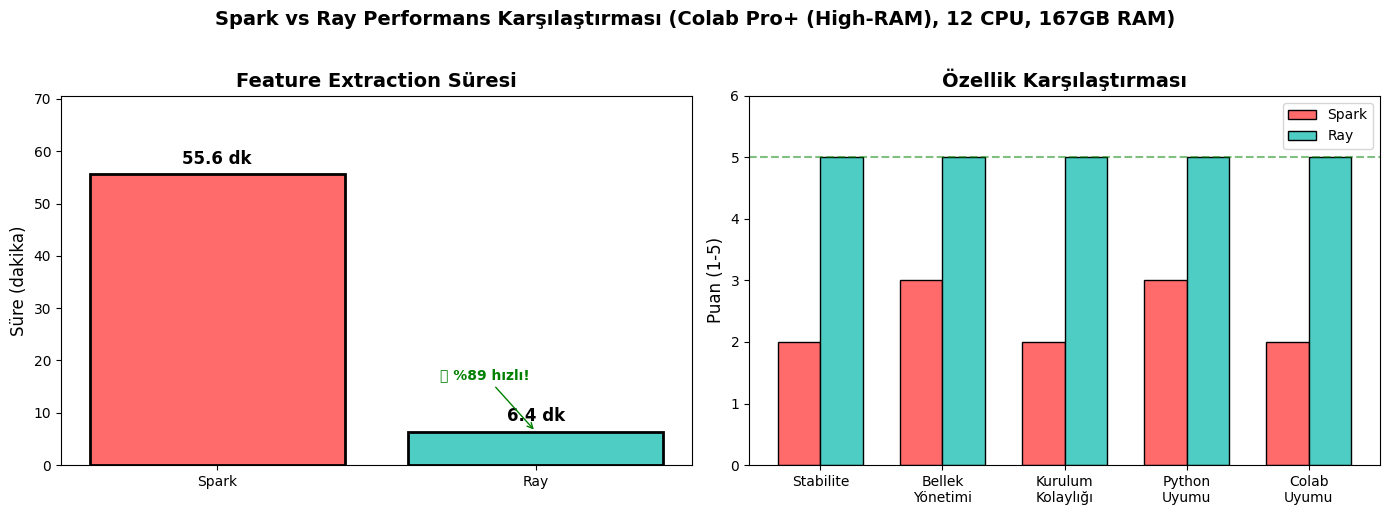


✅ Karşılaştırma görseli kaydedildi: spark_vs_ray_comparison.png


In [ ]:
# =============================================================================
# GÖRSEL KARŞILAŞTIRMA
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Feature Extraction Süresi Karşılaştırması
frameworks = ['Spark', 'Ray']
fe_times = [SPARK_FEATURE_EXTRACTION_TIME, RAY_FEATURE_EXTRACTION_TIME]
colors = ['#FF6B6B', '#4ECDC4']

axes[0].bar(frameworks, fe_times, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Süre (dakika)', fontsize=12)
axes[0].set_title('Feature Extraction Süresi', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(fe_times) + 15)

for i, v in enumerate(fe_times):
    axes[0].text(i, v + 2, f'{v:.1f} dk', ha='center', fontsize=12, fontweight='bold')

# Spark'ın çöktüğünü belirt
if SPARK_CRASHED:
    axes[0].annotate('❌ Çöktü!', xy=(0, SPARK_FEATURE_EXTRACTION_TIME),
                    xytext=(0.3, SPARK_FEATURE_EXTRACTION_TIME + 10),
                    fontsize=10, color='red', fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='red'))

# Ray'in kazandığını belirt
axes[0].annotate(f'🏆 %{speed_improvement:.0f} hızlı!', xy=(1, RAY_FEATURE_EXTRACTION_TIME),
                xytext=(0.7, RAY_FEATURE_EXTRACTION_TIME + 10),
                fontsize=10, color='green', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='green'))

# 2. Özellik Karşılaştırması (Radar benzeri bar chart)
features = ['Stabilite', 'Bellek\nYönetimi', 'Kurulum\nKolaylığı', 'Python\nUyumu', 'Colab\nUyumu']
spark_scores = [2, 3, 2, 3, 2]  # 1-5 arası
ray_scores = [5, 5, 5, 5, 5]

x = np.arange(len(features))
width = 0.35

bars1 = axes[1].bar(x - width/2, spark_scores, width, label='Spark', color='#FF6B6B', edgecolor='black')
bars2 = axes[1].bar(x + width/2, ray_scores, width, label='Ray', color='#4ECDC4', edgecolor='black')

axes[1].set_ylabel('Puan (1-5)', fontsize=12)
axes[1].set_title('Özellik Karşılaştırması', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(features, fontsize=10)
axes[1].legend(loc='upper right')
axes[1].set_ylim(0, 6)
axes[1].axhline(y=5, color='green', linestyle='--', alpha=0.5)

# Suptitle
fig.suptitle(f'Spark vs Ray Performans Karşılaştırması ({colab_type}, {cpu_count} CPU, {ram_gb:.0f}GB RAM)',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/spark_vs_ray_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Karşılaştırma görseli kaydedildi: spark_vs_ray_comparison.png")


## 24. Tüm Benchmark Sonuçlarını Görüntüle

Kaydedilmiş tüm benchmark dosyalarını görüntüler.


In [ ]:
# =============================================================================
# TÜM BENCHMARK SONUÇLARINI GÖRÜNTÜLE
# =============================================================================

import json
import os

# Benchmark dosya yolları
RAY_BENCHMARK_PATH = "/content/drive/MyDrive/cv_benchmarks/ray_benchmark.json"
SPARK_BENCHMARK_PATH = "/content/drive/MyDrive/spark_colabratory_2/benchmark/spark_benchmark.json"

print("="*70)
print("📊 KAYDEDİLMİŞ TÜM BENCHMARK SONUÇLARI")
print("="*70)

all_benchmarks = []

# Ray benchmark'ı oku
if os.path.exists(RAY_BENCHMARK_PATH):
    with open(RAY_BENCHMARK_PATH, 'r') as f:
        ray_data = json.load(f)
    all_benchmarks.append(ray_data)
    print(f"\n✅ Ray benchmark okundu: {RAY_BENCHMARK_PATH}")
else:
    print(f"\n⚠️ Ray benchmark bulunamadı: {RAY_BENCHMARK_PATH}")

# Spark benchmark'ı oku
if os.path.exists(SPARK_BENCHMARK_PATH):
    with open(SPARK_BENCHMARK_PATH, 'r') as f:
        spark_data = json.load(f)
    all_benchmarks.append(spark_data)
    print(f"✅ Spark benchmark okundu: {SPARK_BENCHMARK_PATH}")
else:
    print(f"⚠️ Spark benchmark bulunamadı: {SPARK_BENCHMARK_PATH}")

# Benchmark'ları görüntüle
if all_benchmarks:
    print(f"\n📁 Bulunan benchmark sayısı: {len(all_benchmarks)}\n")

    for data in all_benchmarks:
        print(f"{'='*50}")
        print(f"📌 {data['framework']}")
        print(f"{'='*50}")
        print(f"   Tarih: {data.get('timestamp', 'N/A')}")
        print(f"   Durum: {'✅ Tamamlandı' if data.get('status') == 'completed' else '❌ Başarısız'}")
        print(f"   Çöktü mü: {'❌ Evet' if data.get('crashed') else '✅ Hayır'}")
        print(f"\n   💻 Sistem:")
        system = data.get('system', {})
        print(f"      CPU: {system.get('cpu_count', 'N/A')} çekirdek")
        print(f"      RAM: {system.get('ram_gb', 'N/A')} GB")
        print(f"      Tip: {system.get('colab_type', 'N/A')}")
        print(f"\n   ⏱️ Feature Extraction:")
        fe = data.get('feature_extraction', {})
        print(f"      Train örnekleri: {fe.get('train_samples', 'N/A'):,}")
        print(f"      Toplam süre: {fe.get('total_time_minutes', 'N/A')} dakika")
        print()

    # Karşılaştırma özeti
    if len(all_benchmarks) >= 2:
        print("\n" + "="*70)
        print("🏆 KARŞILAŞTIRMA ÖZETİ")
        print("="*70)

        # Framework'lere göre bul
        spark_bench = next((b for b in all_benchmarks if b['framework'] == 'Spark'), None)
        ray_bench = next((b for b in all_benchmarks if b['framework'] == 'Ray'), None)

        if spark_bench and ray_bench:
            spark_time = spark_bench['feature_extraction']['total_time_minutes']
            ray_time = ray_bench['feature_extraction']['total_time_minutes']

            if ray_time < spark_time:
                winner = "Ray"
                improvement = ((spark_time - ray_time) / spark_time) * 100
            else:
                winner = "Spark"
                improvement = ((ray_time - spark_time) / ray_time) * 100

            print(f"\n   🥇 Kazanan: {winner}")
            print(f"   📈 Hız farkı: %{improvement:.1f}")
            print(f"\n   Spark: {spark_time:.1f} dk {'(çöktü)' if spark_bench.get('crashed') else ''}")
            print(f"   Ray:   {ray_time:.1f} dk {'(çöktü)' if ray_bench.get('crashed') else ''}")
else:
    print(f"\n⚠️ Hiç benchmark dosyası bulunamadı.")
    print(f"   Önce Spark veya Ray notebook'larını çalıştırın.")


📊 KAYDEDİLMİŞ TÜM BENCHMARK SONUÇLARI

⚠️ Ray benchmark bulunamadı: /content/drive/MyDrive/cv_benchmarks/ray_benchmark.json
✅ Spark benchmark okundu: /content/drive/MyDrive/spark_colabratory_2/benchmark/spark_benchmark.json

📁 Bulunan benchmark sayısı: 1

📌 Spark
   Tarih: 2025-12-22T21:03:35.729142
   Durum: ✅ Tamamlandı
   Çöktü mü: ✅ Hayır

   💻 Sistem:
      CPU: 12 çekirdek
      RAM: 167.1 GB
      Tip: Colab Pro+ (High-RAM)

   ⏱️ Feature Extraction:
      Train örnekleri: 60,322
      Toplam süre: 55.6 dakika

